In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as pre
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_x = pd.read_csv('datafiles/train.csv', index_col = 'PassengerId',
                    usecols = ['PassengerId',
                               'Pclass', 
                               'Sex', 
                               'Age', 
                               'SibSp', 
                               'Parch', 
                               'Embarked'])
train_x.columns = [i.lower() for i in train_x.columns]

train_y = pd.read_csv('datafiles/train.csv', index_col = 'PassengerId',
                      usecols = ['PassengerId', 'Survived'])

In [3]:
# converts to numerics
train_x['sex'] = train_x['sex'].replace({'male':'0','female':'1'})
train_x['embarked'] = train_x['embarked'].replace({'C':'0','Q':'1','S':'2'})

In [18]:
# what is the proportion of survived/died in the dataset?
percent_survived = round(len(train_y[train_y['Survived'] == 1]) / len(train_y) * 100,2)
print(str(percent_survived)+"% passengers survived - we need to be more accurate than this")
# since it's unbalanced we will use a confusion matrix

38.38% passengers survived - we need to be more accurate than this


In [5]:
# fill nans with mean on the column
filler = SimpleImputer()
filled = filler.fit_transform(train_x)
filled_x = pd.DataFrame(filled, train_x.index, train_x.columns)

with open("fillnas.pkl", mode = "wb") as file:
    pickle.dump(filler, file)

In [6]:
# scale all columns to be between 0 and 1
scaler = pre.MinMaxScaler()
scaled = scaler.fit_transform(filled_x)
scaled_x = pd.DataFrame(scaled, filled_x.index, filled_x.columns)

with open("scaler.pkl", mode = "wb") as file:
    pickle.dump(scaler, file)

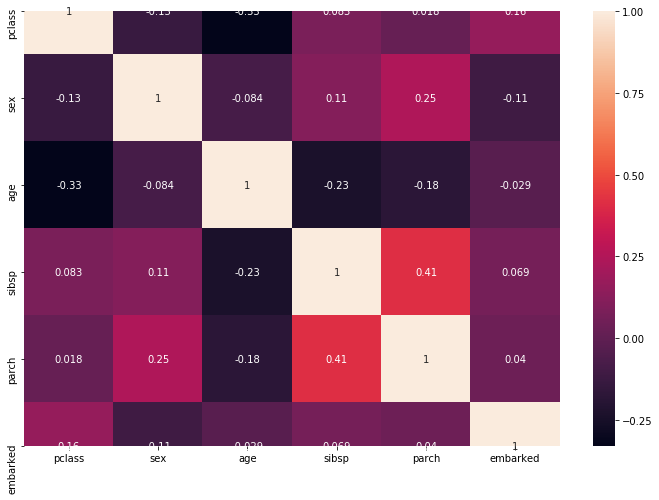

In [7]:
# quick look at correlations
plt.figure(figsize = (12,8))
sns.heatmap(scaled_x.corr(), annot = True)
plt.show()

In [21]:
reg = LogisticRegression(solver = 'liblinear')

In [22]:
# cross validation
scores = cross_val_score(reg, scaled_x, np.ravel(train_y), cv = 5, 
                         scoring = 'recall') # we're using recall because there are fewer positives than negatives
                                             # so we need to be careful we don't just inflate accuracy by predicting negatives
print(scores.mean())

0.6928388746803069


In [10]:
# trains the model
reg.fit(scaled_x, np.ravel(train_y))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# saves the model
with open("logistic_regression.pkl", mode = "wb") as file:
    pickle.dump(reg, file)

## Predictions

In [12]:
# imports the actual test dataframe that gets submitted to kaggle
test = pd.read_csv('datafiles/test.csv', index_col = 'PassengerId',
                    usecols = ['PassengerId',
                               'Pclass', 
                               'Sex', 
                               'Age', 
                               'SibSp', 
                               'Parch', 
                               'Embarked'])
test.columns = [i.lower() for i in test.columns]

In [13]:
# converts to numerics
test['sex'] = test['sex'].replace({'male':'0','female':'1'})
test['embarked'] = test['embarked'].replace({'C':'0','Q':'1','S':'2'})

In [14]:
filled = pd.DataFrame(filler.transform(test), test.index, test.columns)
scaled = pd.DataFrame(scaler.transform(filled), filled.index, filled.columns)

In [15]:
result = reg.predict(scaled)

In [16]:
output=pd.DataFrame(result, index = test.index, columns = ['Survived'])

In [17]:
output.to_csv('datafiles/predictions.csv')